# Introduction
Predicting Next-Day Stock Prices Using LSTM: An AI-Powered Approach for Investment Decision-Making

Authors: William Acuna, Sinthuja Bates, Frank Ivey



# Section 1: Setup Notebook
In this section, we will install the necessary packages and import libraries needed for our code.

### Install packages

In [ ]:
import importlib
import subprocess

def install_package(package_name, pip_name=None):
    """
    Install missing packages
    """
    if pip_name is None:
        pip_name = package_name
    if importlib.util.find_spec(package_name) is None:
        print(f'{package_name} not found. Installing...')
        subprocess.run(['pip', 'install', pip_name, '--quiet'])


install_package('matplotlib')
install_package('alpha_vantage', 'alpha-vantage')
install_package('sklearn')
install_package('pandas')

alpha_vantage not found. Installing...


### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import figure
from pandas._config import dates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

print("All libraries loaded")

All libraries loaded


# Section 2: Exploratory Data Analysis
In this section, we perform exploratory data analysis (EDA) to understand the dataset's structure, characteristics, and key statistics. This involves inspecting the data for missing values, data types, and basic descriptive statistics. We will also visualize the data to identify patterns, trends, and potential anomalies that could impact our analysis and modeling efforts.

#### Configuration settings for Alpha Vantage API, data processing, plotting and model training

In [ ]:
config = {
    "alpha_vantage": {
        "key": '29KXSVMSR5B5IYGT',
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",

    },
    "data": {
        "window_size": 30,
        "train_split_size": 0.80,
    },
    "plots": {
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 16,
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",  # or "cuda" if you have a GPU
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
        "early_stopping_patience": 10,
    }
}

#### Set start and end dates for data retrieval

In [ ]:
start_date = date.today()
print(f"Start date for data retrieval is: {start_date}")
end_date = (datetime.today() - timedelta(days=3*365)).date()
print(f"End date for data retrieval (3 years ago) is: {end_date}")

Start date for data retrieval is: 2024-08-05
End date for data retrieval (3 years ago) is: 2021-08-06


#### Create function to download the data, then plot the daily adjusted close price

Number data points 752 from 2021-08-06 to 2024-08-02


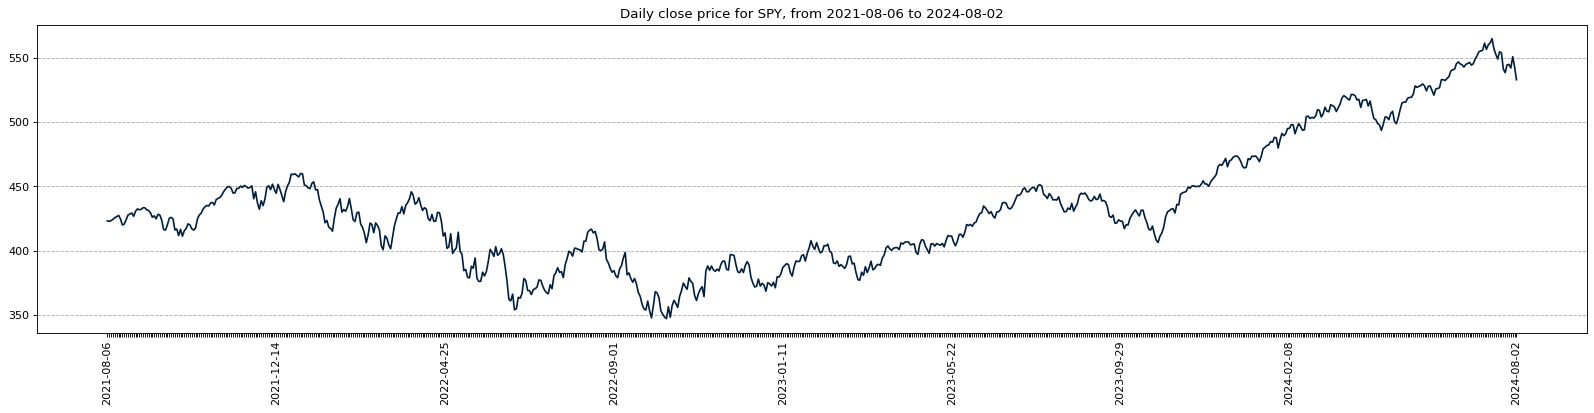

In [ ]:
def download_data(config):
    """
    Download daily adjusted stock price data using the Alpha Vantage API.
    """
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])


    data_date = [date for date in data.keys()]
    data_date = [date for date in data.keys() if end_date <= datetime.strptime(date, '%Y-%m-%d').date() <= start_date]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_date]


    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range


data_date, data_close_price, num_data_points, display_date_range = download_data(config)


fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


#### Print the number of data points and the last close price

In [ ]:
print(f"Number of data points: {num_data_points}")
print(f"Last close price: {data_close_price[-1]}")

Number of data points: 752
Last close price: 532.9


#### Build function to retrieve stock technical indicators and function to visualize the dataset. Execute the functions to visualize the dataset.

Stock Technical Indicators used:

SMA (Simple Moving Average) data

RSI (Relative Strength Index) data

MACD data

Bollinger Bands data

Stochastic Oscillator data

ADX data

CCI data

Aroon data

Williams %R data


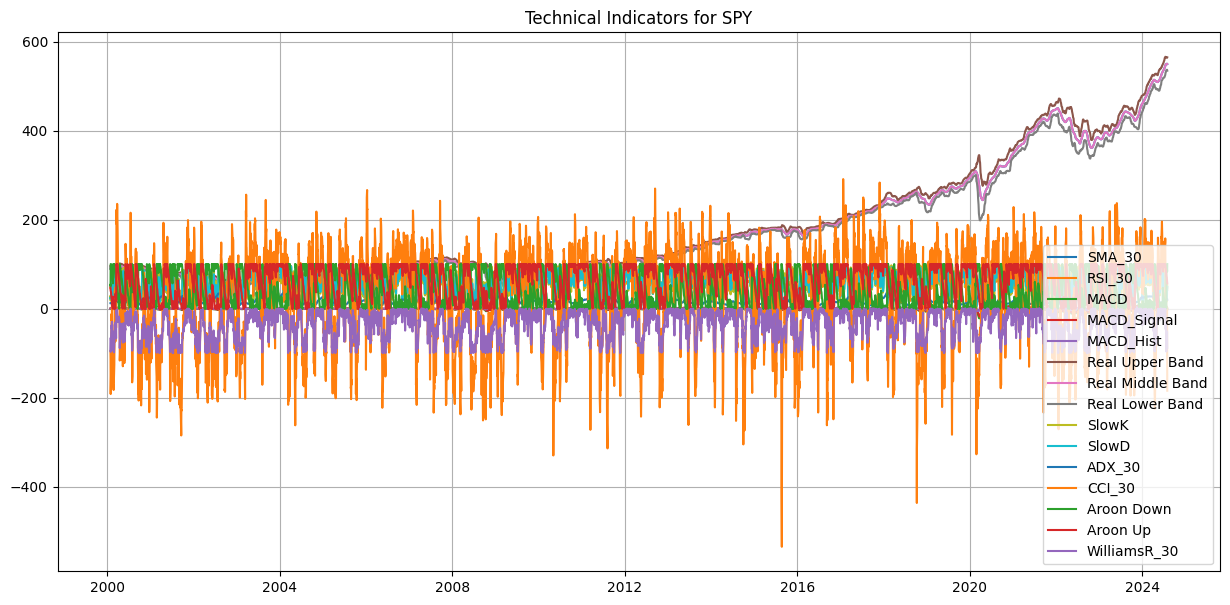

In [ ]:
def retrieve_technical_indicators(symbol, api_key):
    """
    Retrieve multiple technical indicators for a given stock symbol using Alpha Vantage API.
    """
    ti = TechIndicators(key=api_key, output_format='pandas')

    sma_data, _ = ti.get_sma(symbol=symbol, interval='daily', time_period=30, series_type='close')
    sma_data = sma_data.rename(columns={'SMA': 'SMA_30'})

    rsi_data, _ = ti.get_rsi(symbol=symbol, interval='daily', time_period=30, series_type='close')
    rsi_data = rsi_data.rename(columns={'RSI': 'RSI_30'})

    macd_data, _ = ti.get_macd(symbol=symbol, interval='daily', series_type='close')

    bbands_data, _ = ti.get_bbands(symbol=symbol, interval='daily', time_period=30, series_type='close')

    stoch_data, _ = ti.get_stoch(symbol=symbol, interval='daily')

    adx_data, _ = ti.get_adx(symbol=symbol, interval='daily', time_period=30)
    adx_data = adx_data.rename(columns={'ADX': 'ADX_30'})

    cci_data, _ = ti.get_cci(symbol=symbol, interval='daily', time_period=30)
    cci_data = cci_data.rename(columns={'CCI': 'CCI_30'})

    aroon_data, _ = ti.get_aroon(symbol=symbol, interval='daily', time_period=30)

    williamsr_data, _ = ti.get_willr(symbol=symbol, interval='daily', time_period=30)
    williamsr_data = williamsr_data.rename(columns={'WILLR': 'WilliamsR_30'})

    dfs = [sma_data, rsi_data, macd_data, bbands_data, stoch_data, adx_data, cci_data, aroon_data, williamsr_data]
    dfs = [sma_data, rsi_data, macd_data, bbands_data, stoch_data, adx_data, cci_data, aroon_data, williamsr_data]
    merged_data = pd.concat(dfs, axis=1).ffill().dropna()

    return merged_data


def visualize_data(data, title):
    """
    Visualize the data with multiple features.
    """
    plt.figure(figsize=(15, 7))
    for column in data.columns:
        plt.plot(data.index, data[column], label=column)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

api_key = config["alpha_vantage"]["key"]
symbol = config["alpha_vantage"]["symbol"]

technical_data = retrieve_technical_indicators(symbol, api_key)

visualize_data(technical_data, f"Technical Indicators for {symbol}")

#### Display a concise summary of the DataFrame

In [ ]:
technical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6169 entries, 2000-01-26 to 2024-08-02
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMA_30            6169 non-null   float64
 1   RSI_30            6169 non-null   float64
 2   MACD              6169 non-null   float64
 3   MACD_Signal       6169 non-null   float64
 4   MACD_Hist         6169 non-null   float64
 5   Real Upper Band   6169 non-null   float64
 6   Real Middle Band  6169 non-null   float64
 7   Real Lower Band   6169 non-null   float64
 8   SlowK             6169 non-null   float64
 9   SlowD             6169 non-null   float64
 10  ADX_30            6169 non-null   float64
 11  CCI_30            6169 non-null   float64
 12  Aroon Down        6169 non-null   float64
 13  Aroon Up          6169 non-null   float64
 14  WilliamsR_30      6169 non-null   float64
dtypes: float64(15)
memory usage: 771.1 KB


### Feature Engineering for Exploratory Data Analysis

1. Convert to DataFrame using the 'data_close_price' and 'dates' variables
2. Convert the index of df_close_price to datetime from object
3. Merge the datasets using an inner join to keep only the common dates


In [ ]:
df_close_price = pd.DataFrame({
    'date': data_date,
    '4. close': data_close_price
})
df_close_price.set_index('date', inplace=True)

df_close_price.index = pd.to_datetime(df_close_price.index)

full_data = pd.merge(df_close_price, technical_data, how='inner', left_index=True, right_index=True)

full_data.sort_index(inplace=True)

#### Display the first few rows of the full dataset

In [ ]:
print("First few rows of the dataset:")
print(full_data.head())

First few rows of the dataset:
              4. close    SMA_30   RSI_30    MACD  MACD_Signal  MACD_Hist  \
date                                                                        
2021-08-06  423.249427  416.0465  61.3671  3.3424       3.3403     0.0021   
2021-08-09  422.905080  416.5414  61.0289  3.3272       3.3377    -0.0105   
2021-08-10  423.431165  417.0263  61.3654  3.3195       3.3340    -0.0146   
2021-08-11  424.483334  417.5390  62.0436  3.3595       3.3391     0.0203   
2021-08-12  425.755503  418.0826  62.8591  3.4540       3.3621     0.0919   

            Real Upper Band  Real Middle Band  Real Lower Band    SlowK  \
date                                                                      
2021-08-06         425.3304          416.0465         406.7627  80.7941   
2021-08-09         425.6505          416.5414         407.4322  93.3379   
2021-08-10         426.0010          417.0263         408.0517  88.4810   
2021-08-11         426.4011          417.5390         

#### Display the shape of the dataset

In [ ]:
print("Shape of the dataset (rows, columns):")
print(full_data.shape)

Shape of the dataset (rows, columns):
(752, 16)


#### Display number of datasets and data range

In [ ]:
num_data_points = len(full_data)
data_date = full_data.index
data_date = pd.to_datetime(full_data.index)

first_date = data_date[0].strftime('%Y-%m-%d')
last_date = data_date[-1].strftime('%Y-%m-%d')
display_date_range = f"from {first_date} to {last_date}"
data_close_price = full_data['4. close']

print("Number data points", num_data_points, display_date_range)

Number data points 752 from 2021-08-06 to 2024-08-02


# Section 3: Data Cleaning
In this section, we perform essential data cleaning and preparation tasks, including:
- Normalizing the data using MinMaxScaler to ensure feature scaling.
- Preparing input (X) and output (Y) data for modeling by creating time windows.
- Splitting the dataset into training and validation sets.
- Preparing data for visualization and plotting.
- Defining custom Dataset and DataLoader classes for time series data to facilitate batch processing and shuffling during model training and validation.









In [ ]:
class Normalizer():
    def __init__(self):
        """
        Initialize the Normalizer class.
        """
        self._mu = None
        self._sd = None

    def fit_transform(self, x):
        """
        Fit the normalizer on the input data and apply normalization.
        :param x: Numpy array of input data.
        :return: Normalized data.
        """
      x_np = np.array(x)
      self._mu = np.mean(x_np, axis=(0), keepdims=True)
      self._sd = np.std(x_np, axis=(0), keepdims=True)

      normalized_x = (x_np - self._mu)/self._sd
      return normalized_x

    def inverse_transform(self, x, feature_idx=0):
      """
      Revert the normalized data back to its original scale.
      :param x: Numpy array of normalized data.
      :param feature_idx: Index of the feature for which the inverse transformation should be applied. Default is 0.
      :return: De-normalized data.
      """
      if self._mu is None or self._sd is None:
        raise ValueError("fit_transform method should be called before inverse_transform.")

      mu = self._mu[0][feature_idx]
      sd = self._sd[0][feature_idx]

      return (x * sd) + mu

#### Configure the MinMaxScaler to normalize features
1. Initialize MinMaxScaler for normalizing the entire dataset
2. Apply MinMaxScaler to normalize the entire dataset
3. Initialize another MinMaxScaler for normalizing a single feature (close price
4. Extract the '4. close' column from the dataset to normalize
5. Apply MinMaxScaler to normalize the '4. close' feature

In [ ]:
scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(full_data)


single_feature_scaler = MinMaxScaler()

single_feature = full_data[['4. close']]

normalized_data_close_price = single_feature_scaler.fit_transform(single_feature)

#### Create functions to prep data for applying windowing technique to Time Series Dataset and Visualize the windowed dataset

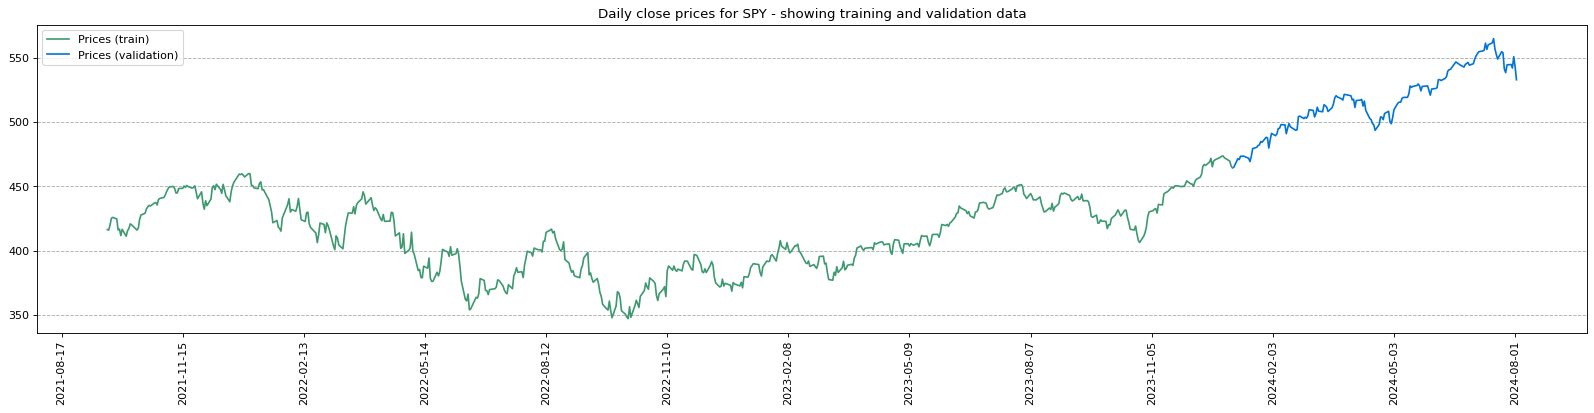

In [ ]:
def prepare_data_x(x, window_size):
    """
    Prepare input data with sliding window approach for time series forecasting.
    :param x: Numpy array of input data.
    :param window_size: Size of the sliding window.
    :return: Tuple containing:
        - Numpy array of input data windows.
        - Last window of data for unseen prediction.
    """
    n_row = x.shape[0] - window_size + 1
    output = [x[i:i + window_size] for i in range(n_row - 1)]
    return np.array(output), x[-window_size:]

def prepare_data_y(x, window_size):
    """
    Prepare output data (labels) using the next day's value.
    :param x: Numpy array of input data.
    :param window_size: Size of the sliding window used in preparation.
    :return: Numpy array of labels for each input window.
    """

    output = x[window_size:, 0]
    return output



data_x, data_x_unseen = prepare_data_x(normalized_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"])


split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]


to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)


window_size_offset = config["data"]["window_size"]
to_plot_data_y_train[window_size_offset:split_index + window_size_offset] = single_feature_scaler.inverse_transform(data_y_train.reshape(-1, 1)).flatten()
to_plot_data_y_val[split_index + window_size_offset:] = single_feature_scaler.inverse_transform(data_y_val.reshape(-1, 1)).flatten()


to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

def plot_data(full_data, to_plot_data_y_train, to_plot_data_y_val, config):
    """
    Plot the training and validation data with configuration options.
    :param full_data: DataFrame containing the full dataset with dates.
    :param to_plot_data_y_train: Numpy array of training data for plotting.
    :param to_plot_data_y_val: Numpy array of validation data for plotting.
    :param config: Dictionary containing plotting configuration parameters.
    """
    plot_config = config.get("plots", {})
    color_train = plot_config.get("color_train", "blue")
    color_val = plot_config.get("color_val", "red")
    xticks_interval = plot_config.get("xticks_interval", 90)
    symbol = config.get("alpha_vantage", {}).get("symbol", "Unknown Symbol")

    data_date = full_data.index
    num_data_points = len(data_date)

    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    ax.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=color_train)
    ax.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=color_val)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=xticks_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')

    ax.set_title(f"Daily close prices for {symbol} - showing training and validation data")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()
    plt.show()

plot_data(full_data, to_plot_data_y_train, to_plot_data_y_val, config)

#### Create Class for Time Series Dataset, initialize a new one, view the shape of dataset, and add to the dataloader

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    Custom dataset class for time series data.
    """
    def __init__(self, x, y):
        """
        Initialize the dataset with input (x) and output (y) data.
        :param x: Numpy array of input features.
        :param y: Numpy array of target labels.
        """
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        """
        Return the number of samples in the dataset.
        :return: Number of samples.
        """
        return len(self.x)

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset at the specified index.
        :param idx: Index of the sample to retrieve.
        :return: Tuple containing input features and target label for the given index.
        """
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (577, 30, 16) (577,)
Validation data shape (145, 30, 16) (145,)


# Section 4: Model Design/Building

#### Build Neural Network Model Classes
1. Long Short Term Memory (LSTM)
2. Artificial Neural Network (ANN)
3. Gated Recurrent Unit (GRU)

In [ ]:
class LSTMModel(nn.Module):
    """
    Custom LSTM model class for time series forecasting.
    """
    def __init__(self, input_size=16, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        x = self.linear_1(x)
        x = self.relu(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [ ]:
class ANNModel(nn.Module):
    """
    Custom ANN model class for time series forecasting.
    """
    def __init__(self, input_size=16, hidden_layer_size=32, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
class GRUModel(nn.Module):
    """
    Custom GRU model class for time series forecasting.
    """
    def __init__(self, input_size=16, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Section 5: Hyper-Parameter Optimization to get best parameters for each model type

#### Create functions to support the training and validation of the models

1. First function takes the data from the dataloader, initialized model object and determines if training or validation. Used for actual training once hyperparameter optimization is completed

2. Second function is used by the RandomizedSearchCV for hyperparameter optimization. The function also is parameterized with the same parameters as the first function.

In [ ]:
def run_epoch(dataloader, model_type, is_training=False):
  """
  Run a single epoch of training or validation.
  """
    epoch_loss = 0

    if is_training:
        model_type.train()
    else:
        model_type.eval()

    for x, y in dataloader:
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model_type(x)

        # Check shapes and print them for debugging
        #print("Shape of out:", out.shape)
        #print("Shape of y:", y.shape)

        # Reshape out to match y
        out = out.view(out.size(0), -1).mean(dim=1)

        loss = criterion(out,y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [ ]:
def run_epoch_rscv(dataloader, model_type, is_training=False):
    """
    Run a single epoch of training or validation.
    """
    epoch_loss = 0
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_type.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)
    if is_training:
        model_type.train()
        #print("Training")
    else:
        model_type.eval()
        #print("Validation")

    for x, y in dataloader:
        if is_training:
          optimizer.zero_grad()

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model_type(x)
        out = out.view(out.size(0), -1).mean(dim=1)
        loss = criterion(out, y)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / x.size(0))

    lr = scheduler.get_last_lr()[0]
    return epoch_loss, lr

#### Load Time Series data set

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

### Hyper-Parameter Optimization

Use RandomizedSearchCV to find the best parameters from a manually made list of parameters

1. Step 1: Define a function to create the model
2. Step 2: Define a function to train the model
3. Step 3: Set up the parameter grid
4. Step 4: Integrate with RandomizedSearchCV
5. Step 5: View the results in the best_models_estimators list
6. Step 6: View the list of hyper-parameters that will be used in training and validation. The list is grouped by the sequence as the model objects

In [ ]:
def create_model(model_type, input_size=16, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
    """
    Create a model based on the specified type.
    """
    if model_type == 'LSTM':
        return LSTMModel(input_size, hidden_layer_size, num_layers, output_size, dropout)
    elif model_type == 'ANN':
        return ANNModel(input_size, hidden_layer_size, output_size, dropout)
    elif model_type == 'GRU':
        return GRUModel(input_size, hidden_layer_size, num_layers, output_size, dropout)
    else:
        raise ValueError("Unknown model type")

In [ ]:
class ModelTrainer(BaseEstimator, RegressorMixin):
    """
    Custom model trainer class for time series forecasting.
    """
    def __init__(self, model_type='LSTM', input_size=16, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        print(model_type)
        self.model_type = model_type
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.model = create_model(model_type, input_size, hidden_layer_size, num_layers, output_size, dropout)

    def fit(self, X, y):
        self.model = self.model.to(config["training"]["device"])
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

        for epoch in range(config["training"]["num_epoch"]):
            loss_train, _ = run_epoch_rscv(train_dataloader, self.model, is_training=True)
            loss_val, _ = run_epoch_rscv(val_dataloader, self.model)
            scheduler.step()

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X).float().to(config["training"]["device"])
            predictions = self.model(X)
            return predictions.cpu().numpy()

In [ ]:
param_dist = {
    'hidden_layer_size': [2, 16, 32, 64],
    'num_layers': [1, 2, 3, 12],
    'dropout': [0.1, 0.2, 0.3, 0.6]
}

In [ ]:
rscv_model_types = ['LSTM', 'ANN', 'GRU']

In [ ]:
best_models = []
best_models_with_estimator = []
for modeltype in rscv_model_types:
    model_trainer = ModelTrainer(model_type=modeltype)
    random_search = RandomizedSearchCV(model_trainer, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
    random_search.fit(dataset_train.x, dataset_train.y)
    best_models.append((random_search.best_params_))
    best_models_with_estimator.append((modeltype, random_search.best_estimator_, random_search.best_params_))
    #print(f"Best parameters for {modeltype}: {random_search.best_params_}")

LSTM
LSTM
Fitting 3 folds for each of 10 candidates, totalling 30 fits
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM
LSTM


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


ANN
ANN
Fitting 3 folds for each of 10 candidates, totalling 30 fits
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN
ANN


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


ANN
GRU
GRU
Fitting 3 folds for each of 10 candidates, totalling 30 fits
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU
GRU


In [ ]:
best_models_with_estimator

[('LSTM',
  ModelTrainer(dropout=0.3, num_layers=12),
  {'num_layers': 12, 'hidden_layer_size': 32, 'dropout': 0.3}),
 ('ANN',
  ModelTrainer(hidden_layer_size=16, model_type='ANN', num_layers=1),
  {'num_layers': 1, 'hidden_layer_size': 16, 'dropout': 0.2}),
 ('GRU',
  ModelTrainer(dropout=0.1, model_type='GRU', num_layers=3),
  {'num_layers': 3, 'hidden_layer_size': 32, 'dropout': 0.1})]

In [ ]:
best_models

[{'num_layers': 12, 'hidden_layer_size': 32, 'dropout': 0.3},
 {'num_layers': 1, 'hidden_layer_size': 16, 'dropout': 0.2},
 {'num_layers': 3, 'hidden_layer_size': 32, 'dropout': 0.1}]

# Section 6: Model Training

### Initialize the models and apply the best parameters discovered from hyper-parameter optimization procedures and then add the model objects to a list

We are initializing LSTM model, ANN model, and GRU model

In [ ]:
lstmmodel = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=best_models[0]['hidden_layer_size'], num_layers=best_models[0]['num_layers'], output_size=1, dropout=best_models[0]['dropout'])
lstmmodel = lstmmodel.to(config["training"]["device"])

In [ ]:
annmodel = ANNModel(input_size=config["model"]["input_size"], hidden_layer_size=best_models[1]['hidden_layer_size'], output_size=1, dropout=best_models[1]['dropout'])
annmodel = annmodel.to(config["training"]["device"])

In [ ]:
grumodel = GRUModel(input_size=config["model"]["input_size"], hidden_layer_size=best_models[2]['hidden_layer_size'], num_layers=best_models[2]['num_layers'], output_size=1, dropout=best_models[2]['dropout'])
grumodel = grumodel.to(config["training"]["device"])

In [ ]:
model_types = []

In [ ]:
model_types.append(lstmmodel)
model_types.append(annmodel)
model_types.append(grumodel)

### Build Dictionaries to store losses and accuracies for data visiualization and analysis purposes

In [ ]:
train_losses = {}
val_losses = {}
train_accuracies = {}
val_accuracies = {}

### Model Training

Iterate through each initialized model type to get model and iterate through list for number of epochs

In [ ]:
for model_type in model_types:
  model_name = model_type.__class__.__name__
  if model_name not in train_losses:
    train_losses[model_name] = []
  if model_name not in val_losses:
    val_losses[model_name] = []
  if model_name not in train_accuracies:
    train_accuracies[model_name] = []
  if model_name not in val_accuracies:
    val_accuracies[model_name] = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_type.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)
    # print the start time of the model training
    print(f"Start time for {model_type} is: {datetime.now()}")
    for epoch in range(config["training"]["num_epoch"]):
        # Run the training and validation epoch
        loss_train, lr_train = run_epoch(train_dataloader, model_type, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader, model_type)
        scheduler.step()
        # Store the losses and accuracies
        train_losses[model_name].append(loss_train)
        val_losses[model_name].append(loss_val)
        train_accuracies[model_name].append(lr_train)
        val_accuracies[model_name].append(lr_val)

        #print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
        #      .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    # print the end time of the model training
    print(f"End time for {model_type} is: {datetime.now()}")

Start time for LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=12, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=384, out_features=1, bias=True)
) is: 2024-08-04 05:20:58.062202
End time for LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=12, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=384, out_features=1, bias=True)
) is: 2024-08-04 05:22:57.178820
Start time for ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
) is: 2024-08-04 05:22:57.179523
End time for ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Lin

#### Plot the training loss and validation loss curves

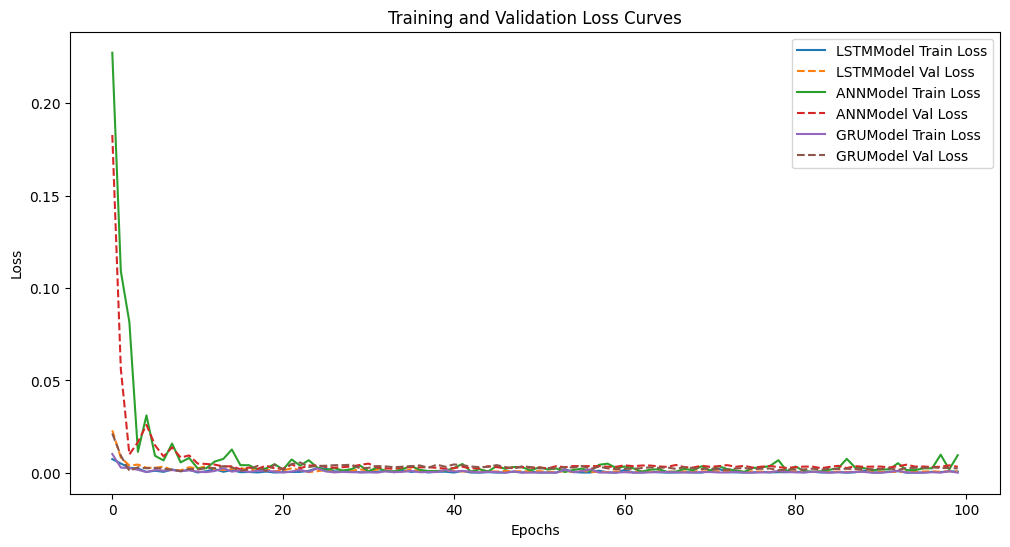

In [ ]:
plt.figure(figsize=(12, 6))
for model_name in train_losses.keys():
    plt.plot(train_losses[model_name], label=f'{model_name} Train Loss')
    plt.plot(val_losses[model_name], label=f'{model_name} Val Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

#### Plot the accuracy curves for each model's training and validation

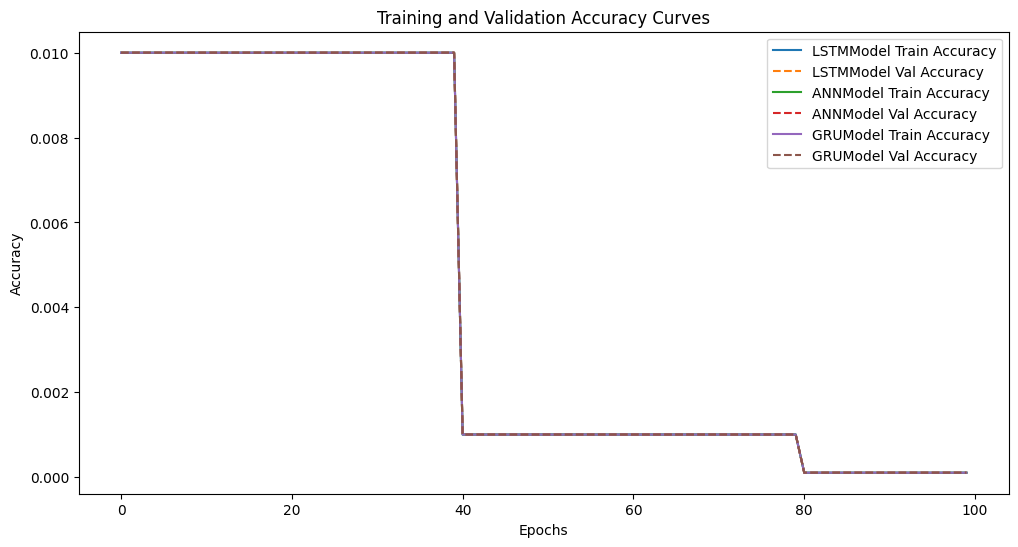

In [ ]:
plt.figure(figsize=(12, 6))
for model_name in train_accuracies.keys():
    plt.plot(train_accuracies[model_name], label=f'{model_name} Train Accuracy')
    plt.plot(val_accuracies[model_name], label=f'{model_name} Val Accuracy', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

#### Re-initialize dataloaders with shuffle=False for sequential data retrieval

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

#### Create function to plot the predictions of each model

In [ ]:
def plot_prices(data_date, data_series, labels, colors, title):
    """Plot a series of data on a single plot.

    Args:
        data_date (array-like): The dates for the x-axis.
        data_series (list of array-like): A list of data series to plot.
        labels (list of str): The labels for each data series.
        colors (list of str): The colors for each data series.
        title (str): The title of the plot.
    """
    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    for series, label, color in zip(data_series, labels, colors):
        ax.plot(data_date, series, label=label, color=color)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')

    ax.set_title(title)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()
    plt.show()

In [ ]:
plot_config = config.get("plots", {})
colors = [plot_config.get("color_actual", "blue"),plot_config.get("color_pred_train", "green"),plot_config.get("color_pred_val", "red")]

# Section 7: Model Evaluation
1. Iterate through model object list and perform model evaluation tasks
2. Take model evaluation predictions and plot them on a chart
3. Data visualization is for Peformance Benchmarking, comparing the difference in model predictions amongst themselves and againsts the true values.

This allows us to determine which model works best based on the performance on this dataset.

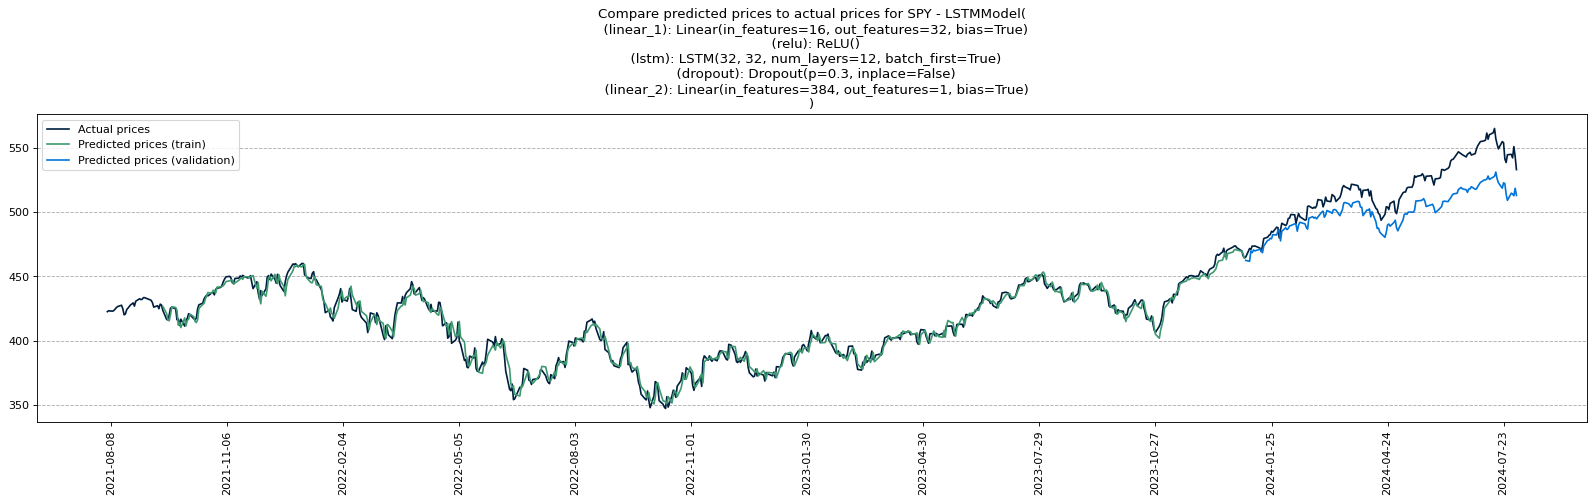

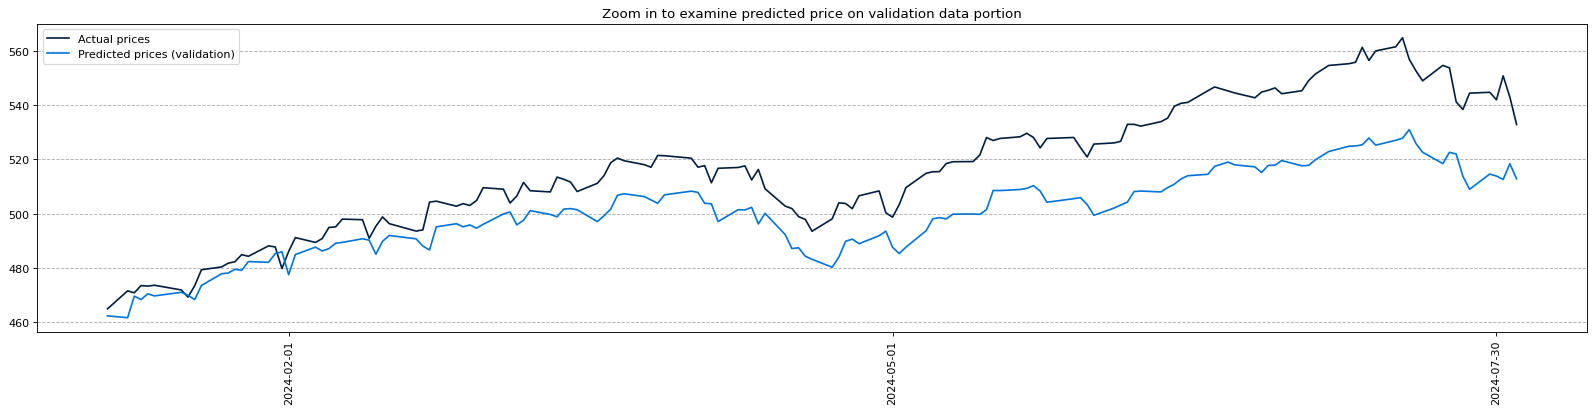

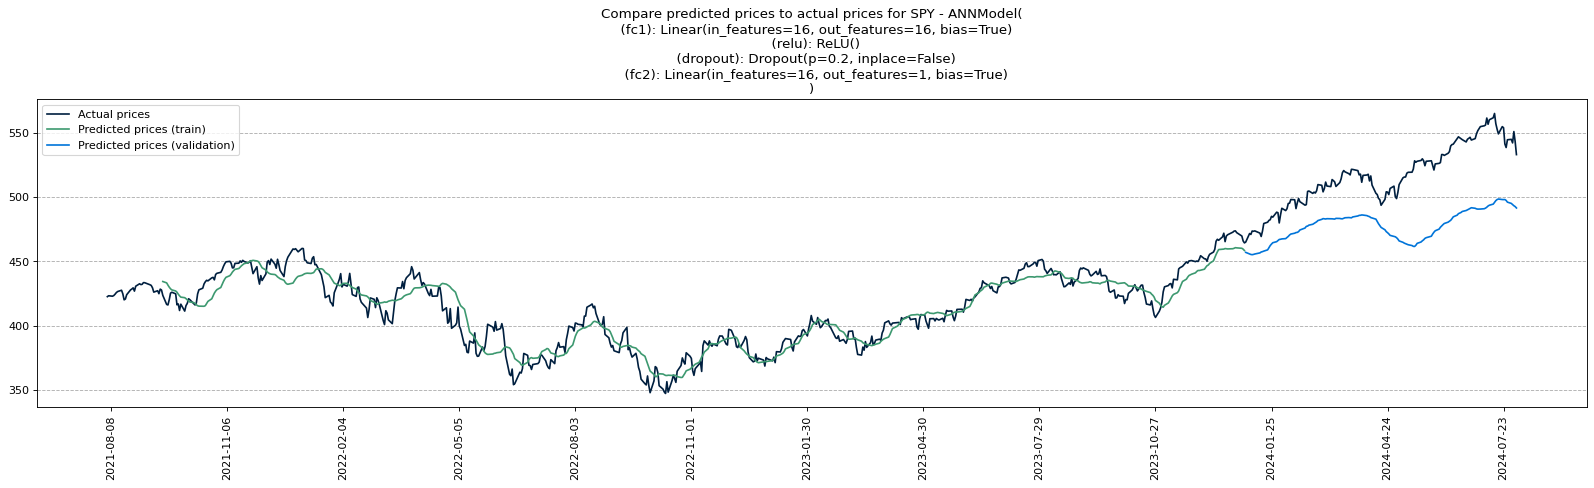

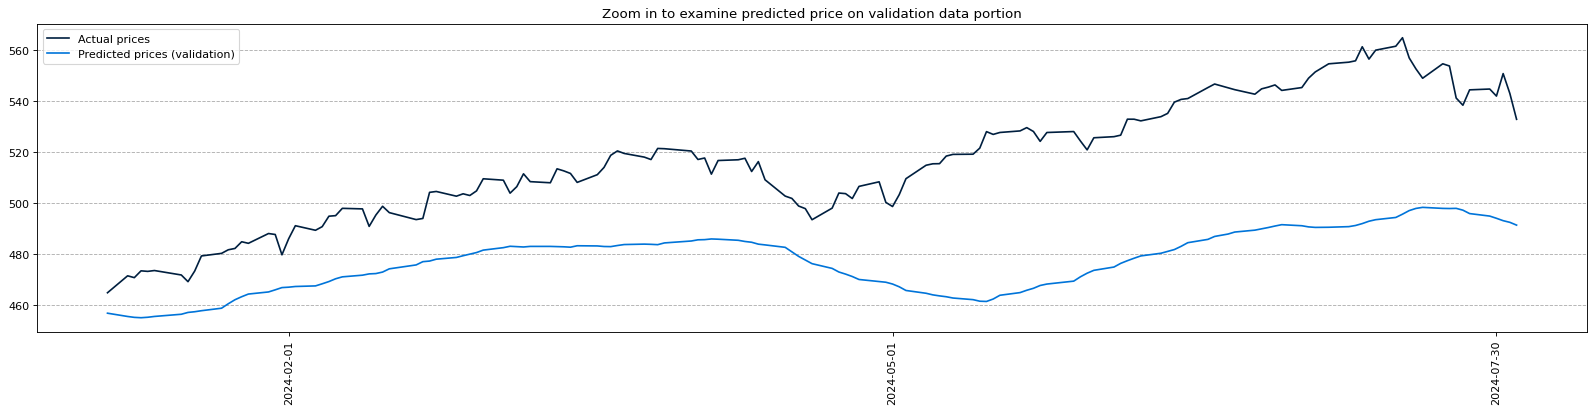

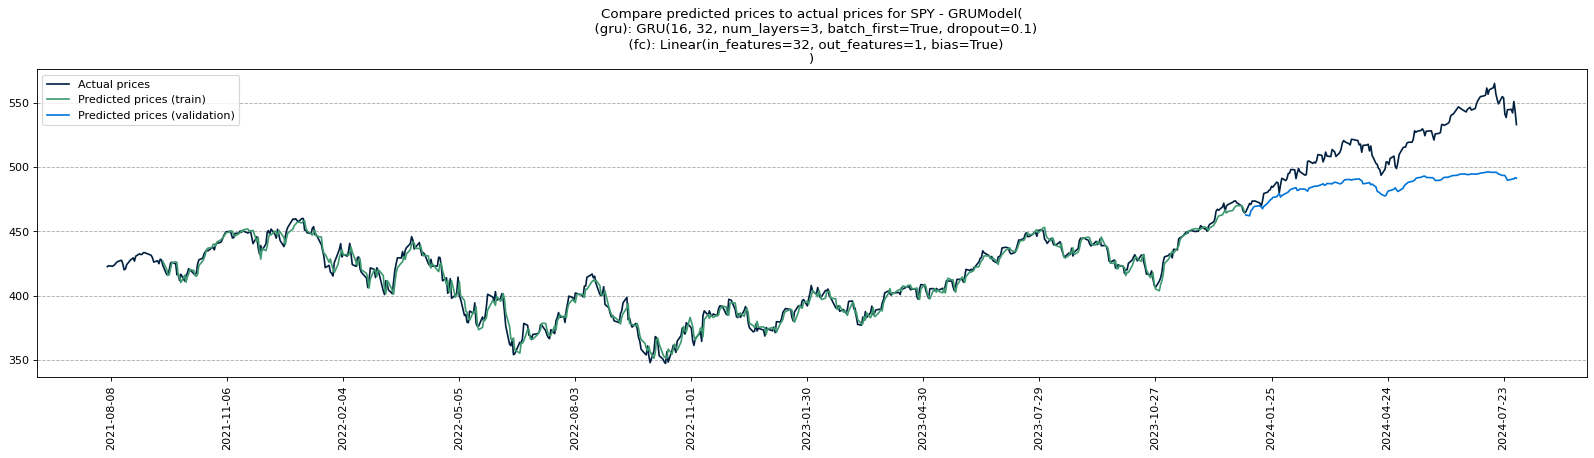

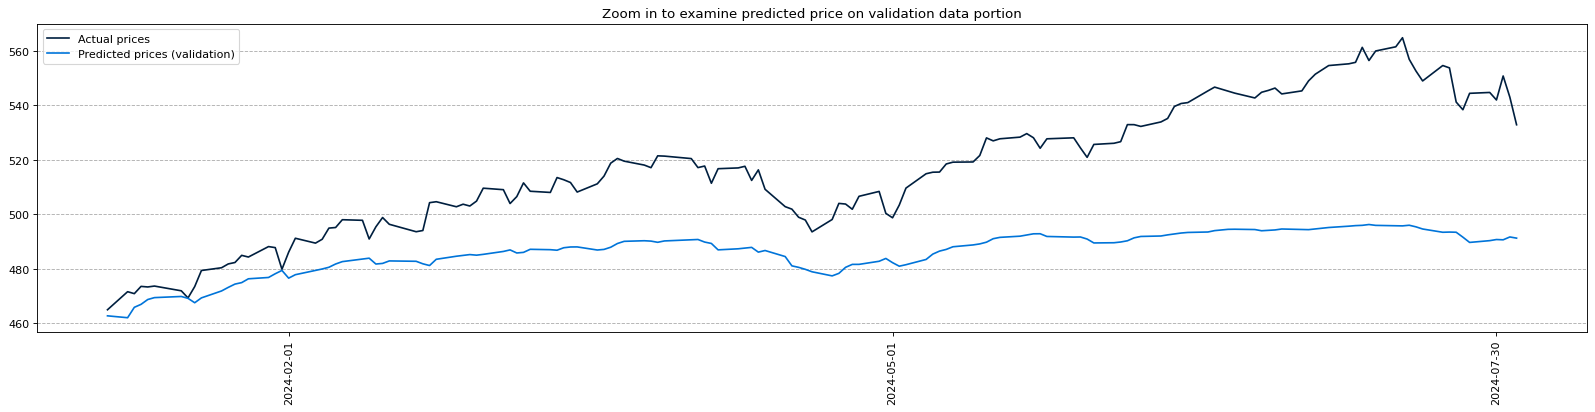

In [ ]:
for model_type in model_types:
    model_type.eval()

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])
        out = model_type(x)
        out = out.view(out.size(0), -1).mean(dim=1)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])
        out = model_type(x)
        out = out.view(out.size(0), -1).mean(dim=1)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))

    num_data_points = len(data_date)
    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index + config["data"]["window_size"]] = single_feature_scaler.inverse_transform(predicted_train.reshape(-1, 1)).flatten()
    to_plot_data_y_val_pred[split_index + config["data"]["window_size"]:] = single_feature_scaler.inverse_transform(predicted_val.reshape(-1, 1)).flatten()

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    data_date = pd.to_datetime(data_date)

    plot_prices(
        data_date=data_date,
        data_series=[data_close_price, to_plot_data_y_train_pred, to_plot_data_y_val_pred],
        labels=["Actual prices", "Predicted prices (train)", "Predicted prices (validation)"],
        colors=colors,
        title=f"Compare predicted prices to actual prices for {config['alpha_vantage']['symbol']} - {model_type}"
    )


    to_plot_data_y_val_subset = single_feature_scaler.inverse_transform(data_y_val.reshape(-1, 1))
    to_plot_predicted_val = single_feature_scaler.inverse_transform(predicted_val.reshape(-1, 1))
    to_plot_data_date = data_date[split_index + config["data"]["window_size"]:]

    color_actual = config["plots"]["color_actual"]
    color_pred_val = config["plots"]["color_pred_val"]

    fig, ax = plt.subplots(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))

    ax.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
    ax.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation='vertical')

    ax.set_title("Zoom in to examine predicted price on validation data portion")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.legend()

    plt.show()

#### Section 8: Model Prediction
1. Iterate through model object list and perform model evaluation tasks
2. Take model evaluation predictions and plot them on a chart
3. Data visualization, used to see the predicted value for the next trading day

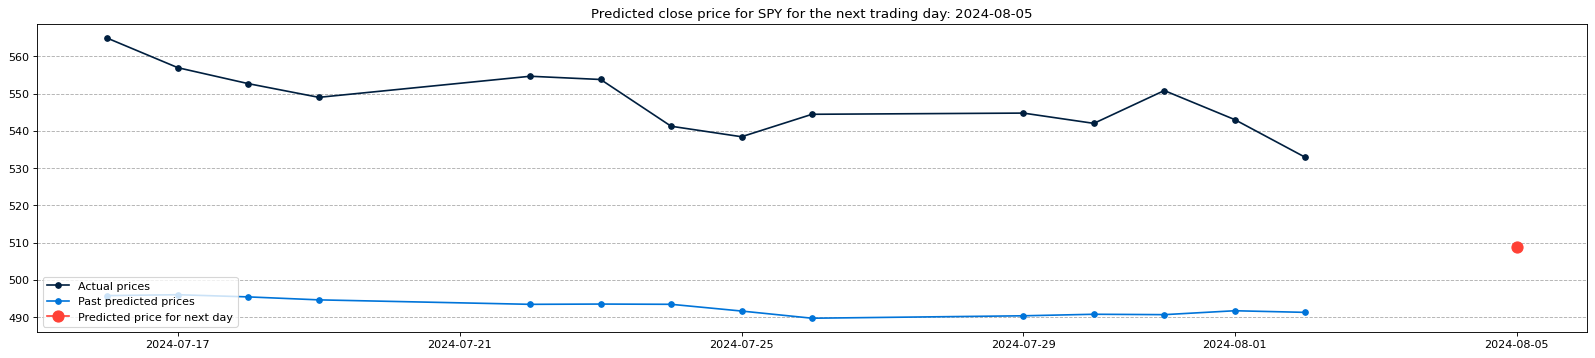

For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=12, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=384, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 508.71
For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=12, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=384, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.14
For model LSTMModel(
  (linear_1): Linear(in_features=16, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=12, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=384, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.13
For model LSTMModel(
  (linear_1): Linear(in_feature

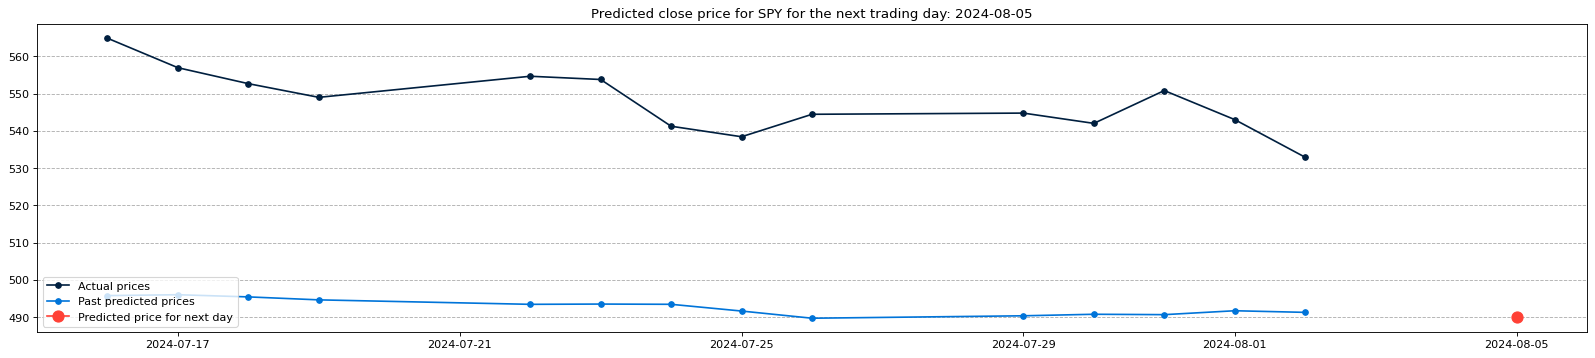

For model ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 489.95
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.14
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.13
For model ANNModel(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
), the Mean Absolute Percentage Error (MAPE): 16.85%


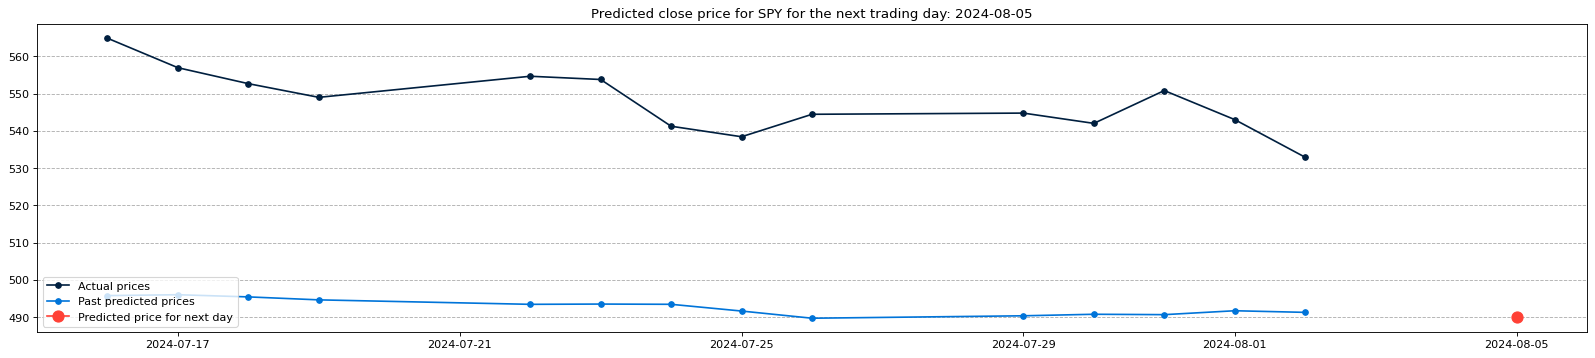

For model GRUModel(
  (gru): GRU(16, 32, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the predicted close price SPY of the next trading day: 490.08
For model GRUModel(
  (gru): GRU(16, 32, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Error (MAE): 0.14
For model GRUModel(
  (gru): GRU(16, 32, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Median Absolute Error (MedAE): 0.13
For model GRUModel(
  (gru): GRU(16, 32, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
), the Mean Absolute Percentage Error (MAPE): 16.85%


In [ ]:
for model_type in model_types:
    model_type.eval()

    x_unseen = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0)
    prediction = model_type(x_unseen)
    prediction = prediction.view(prediction.size(0), -1).mean(dim=1)
    prediction = prediction.cpu().detach().numpy()

    plot_range = 15
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val = single_feature_scaler.inverse_transform(data_y_val[-plot_range + 1:].reshape(-1, 1)).flatten()
    to_plot_data_y_val_pred = single_feature_scaler.inverse_transform(predicted_val[-plot_range + 1:].reshape(-1, 1)).flatten()




    plot_date_test = data_date[-plot_range + 1:].tolist()
    last_date = pd.to_datetime(data_date[-1])
    day_of_week = last_date.weekday()

    if day_of_week == 4:
        next_trading_day = last_date + pd.Timedelta(days=3)
    elif day_of_week == 5:
        next_trading_day = last_date + pd.Timedelta(days=2)
    else:
        next_trading_day = last_date + pd.Timedelta(days=1)

    plot_date_test.append(next_trading_day)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, np.nan, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, np.nan, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, np.nan, to_plot_data_y_test_pred)

    to_plot_data_y_val = np.append(to_plot_data_y_val, np.nan)
    to_plot_data_y_val_pred = np.append(to_plot_data_y_val_pred, np.nan)

    to_plot_data_y_test_pred = np.full(len(plot_date_test), np.nan)
    to_plot_data_y_test_pred[-1] = single_feature_scaler.inverse_transform(prediction.reshape(-1, 1)).flatten()[0]

    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title(f"Predicted close price for {symbol} for the next trading day: {plot_date_test[-1].strftime('%Y-%m-%d')}")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend(loc = 'lower left')
    plt.show()

    predicted_price = to_plot_data_y_test_pred[-1]
    if np.isnan(predicted_price):
        print("Predicted close price of the next trading day is unavailable.")
    else:
        print(f"For model {model_type}, the predicted close price {symbol} of the next trading day:", round(predicted_price, 2))

    abs_diff = np.abs(predicted_val - data_y_val)

    percent_diff = np.abs((predicted_val - data_y_val) / data_y_val) * 100

    mae = np.mean(abs_diff)
    print(f'For model {model_type}, the Mean Absolute Error (MAE): {mae:.2f}')
    medae = np.median(np.abs(predicted_val - data_y_val))
    print(f'For model {model_type}, the Median Absolute Error (MedAE): {medae:.2f}')

    mape = np.mean(percent_diff)
    print(f'For model {model_type}, the Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Section 9: Save Model

Iterate through the list of model objects and save the models

In [ ]:
for model_type in model_types:
    torch.save(model_type.state_dict(), f"{model_type.__class__.__name__}.pth")